<a href="https://colab.research.google.com/github/FrancisDcruz/OpenFairness/blob/main/income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import sys,random
from statistics import mean 
from numpy import nan
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
#from sklego.linear_model import DemographicParityClassifier
#from sklego.metrics import p_percent_score

In [2]:
from google.colab import files
files.upload()    

Saving Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv to Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv


{'Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv': b"Agency Name,EEO-4 Job Category,Pay Band,Employee Status,Race,Ethnicity,Gender,Number of Employees\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Black or African American,Non-Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Native Hawaiian or Pacific Islander,Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Unknown or Choose Not to Disclose,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispa

In [58]:
data=pd.read_csv('/content/Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv')

In [59]:
data.head()

,Agency Name,EEO-4 Job Category,Pay Band,Employee Status,Race,Ethnicity,Gender,Number of Employees
0,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Black or African American,Non-Hispanic or Latino,Female,<5
1,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Native Hawaiian or Pacific Islander,Hispanic or Latino,Female,<5
2,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Hispanic or Latino,Female,<5
3,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Unknown or Choose Not to Disclose,Female,<5
4,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispanic or Latino,Female,<5


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


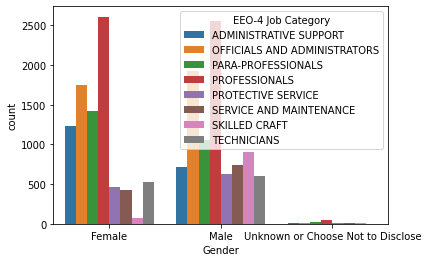

In [60]:
sns.countplot(data.Gender, hue=data['EEO-4 Job Category'])  
plt.show()  

In [61]:
data['income']=''
for i in data.index:
  new=data['Pay Band'][i].split('-')
  my_list = np.array(new).astype(np.float)
  data['income'][i]=mean(my_list)

In [62]:
data['Income'] = np.where(data['income']>50000, 1, 0)
data=data.drop(columns=['income','Pay Band'])

In [63]:
for i in data.index:
  if data['Number of Employees'][i]=='<5':
    data['Number of Employees'][i]=random.randint(1,5)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
cols=['Agency Name', 'EEO-4 Job Category', 'Employee Status','Race', 'Ethnicity', 'Gender']
num_columns=['Number of Employees', 'Income']


In [68]:
data['Number of Employees'] = data['Number of Employees'].astype('int64')

In [97]:
fair_data=data

In [69]:
data=pd.get_dummies(data, columns=cols)

In [70]:
data

,Number of Employees,Income,Agency Name_ADMINISTRATION FOR CHILDREN'S SERVICES,Agency Name_BUSINESS INTEGRITY COMMISSION,Agency Name_DEPARTMENT FOR THE AGING,Agency Name_DEPARTMENT OF BUILDINGS,Agency Name_DEPARTMENT OF CITY PLANNING,Agency Name_DEPARTMENT OF CITYWIDE ADMINISTRATIVE SERVICES,Agency Name_DEPARTMENT OF CONSUMER AFFAIRS,Agency Name_DEPARTMENT OF CORRECTION,Agency Name_DEPARTMENT OF CULTURAL AFFAIRS,Agency Name_DEPARTMENT OF DESIGN AND CONSTRUCTION,Agency Name_DEPARTMENT OF EDUCATION (NON-PEDAGOGICAL),Agency Name_DEPARTMENT OF ENVIRONMENTAL PROTECTION,Agency Name_DEPARTMENT OF FINANCE,Agency Name_DEPARTMENT OF HEALTH AND MENTAL HYGIENE,Agency Name_DEPARTMENT OF HOMELESS SERVICES,Agency Name_DEPARTMENT OF INFORMATION TECHNOLOGY AND TELECOMMUNICATIONS,Agency Name_DEPARTMENT OF INVESTIGATION,Agency Name_DEPARTMENT OF PARKS AND RECREATION,Agency Name_DEPARTMENT OF PROBATION,Agency Name_DEPARTMENT OF RECORDS AND INFORMATION SERVICES,Agency Name_DEPARTMENT OF SANITATION,Agency Name_DEPARTMENT OF SMALL BUSINESS SERVICES,Agency Name_DEPARTMENT OF TRANSPORTATION,Agency Name_DEPARTMENT OF VETERANS' SERVICES,Agency Name_DEPARTMENT OF YOUTH AND COMMUNITY DEVELOPMENT,Agency Name_FIRE DEPARTMENT,Agency Name_HOUSING PRESERVATION AND DEVELOPMENT,Agency Name_HUMAN RESOURCES ADMINISTRATION/DEPARTMENT OF SOCIAL SERVICES,Agency Name_LAW DEPARTMENT,Agency Name_MAYORS OFFICE OF CONTRACT SERVICES,Agency Name_OFFICE OF ADMINISTRATIVE TRIALS AND HEARINGS,Agency Name_OFFICE OF EMERGENCY MANAGEMENT,Agency Name_OFFICE OF LABOR RELATIONS,Agency Name_OFFICE OF MANAGEMENT AND BUDGET,Agency Name_OFFICE OF THE MAYOR,Agency Name_POLICE DEPARTMENT,EEO-4 Job Category_ADMINISTRATIVE SUPPORT,EEO-4 Job Category_OFFICIALS AND ADMINISTRATORS,EEO-4 Job Category_PARA-PROFESSIONALS,EEO-4 Job Category_PROFESSIONALS,EEO-4 Job Category_PROTECTIVE SERVICE,EEO-4 Job Category_SERVICE AND MAINTENANCE,EEO-4 Job Category_SKILLED CRAFT,EEO-4 Job Category_TECHNICIANS,Employee Status_Full-Time,Employee Status_Part-Time,Employee Status_Seasonal,Race_American Indian or Alaska Native,Race_Asian,Race_Black or African American,Race_Native Hawaiian or Pacific Islander,Race_Two or More Races,Race_Unknown or Choose Not to Disclose,Race_White,Ethnicity_Hispanic or Latino,Ethnicity_Non-Hispanic or Latino,Ethnicity_Unknown or Choose Not to Disclose,Gender_Female,Gender_Male,Gender_Unknown or Choose Not to Disclose
0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17766,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
17767,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
17768,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
17769,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0


In [71]:
df1 = data.pop('Income') # remove column b and store it in df1
data['Income']=df1 # add b series as a 'new' column.

In [72]:
data.head()

,Number of Employees,Agency Name_ADMINISTRATION FOR CHILDREN'S SERVICES,Agency Name_BUSINESS INTEGRITY COMMISSION,Agency Name_DEPARTMENT FOR THE AGING,Agency Name_DEPARTMENT OF BUILDINGS,Agency Name_DEPARTMENT OF CITY PLANNING,Agency Name_DEPARTMENT OF CITYWIDE ADMINISTRATIVE SERVICES,Agency Name_DEPARTMENT OF CONSUMER AFFAIRS,Agency Name_DEPARTMENT OF CORRECTION,Agency Name_DEPARTMENT OF CULTURAL AFFAIRS,Agency Name_DEPARTMENT OF DESIGN AND CONSTRUCTION,Agency Name_DEPARTMENT OF EDUCATION (NON-PEDAGOGICAL),Agency Name_DEPARTMENT OF ENVIRONMENTAL PROTECTION,Agency Name_DEPARTMENT OF FINANCE,Agency Name_DEPARTMENT OF HEALTH AND MENTAL HYGIENE,Agency Name_DEPARTMENT OF HOMELESS SERVICES,Agency Name_DEPARTMENT OF INFORMATION TECHNOLOGY AND TELECOMMUNICATIONS,Agency Name_DEPARTMENT OF INVESTIGATION,Agency Name_DEPARTMENT OF PARKS AND RECREATION,Agency Name_DEPARTMENT OF PROBATION,Agency Name_DEPARTMENT OF RECORDS AND INFORMATION SERVICES,Agency Name_DEPARTMENT OF SANITATION,Agency Name_DEPARTMENT OF SMALL BUSINESS SERVICES,Agency Name_DEPARTMENT OF TRANSPORTATION,Agency Name_DEPARTMENT OF VETERANS' SERVICES,Agency Name_DEPARTMENT OF YOUTH AND COMMUNITY DEVELOPMENT,Agency Name_FIRE DEPARTMENT,Agency Name_HOUSING PRESERVATION AND DEVELOPMENT,Agency Name_HUMAN RESOURCES ADMINISTRATION/DEPARTMENT OF SOCIAL SERVICES,Agency Name_LAW DEPARTMENT,Agency Name_MAYORS OFFICE OF CONTRACT SERVICES,Agency Name_OFFICE OF ADMINISTRATIVE TRIALS AND HEARINGS,Agency Name_OFFICE OF EMERGENCY MANAGEMENT,Agency Name_OFFICE OF LABOR RELATIONS,Agency Name_OFFICE OF MANAGEMENT AND BUDGET,Agency Name_OFFICE OF THE MAYOR,Agency Name_POLICE DEPARTMENT,EEO-4 Job Category_ADMINISTRATIVE SUPPORT,EEO-4 Job Category_OFFICIALS AND ADMINISTRATORS,EEO-4 Job Category_PARA-PROFESSIONALS,EEO-4 Job Category_PROFESSIONALS,EEO-4 Job Category_PROTECTIVE SERVICE,EEO-4 Job Category_SERVICE AND MAINTENANCE,EEO-4 Job Category_SKILLED CRAFT,EEO-4 Job Category_TECHNICIANS,Employee Status_Full-Time,Employee Status_Part-Time,Employee Status_Seasonal,Race_American Indian or Alaska Native,Race_Asian,Race_Black or African American,Race_Native Hawaiian or Pacific Islander,Race_Two or More Races,Race_Unknown or Choose Not to Disclose,Race_White,Ethnicity_Hispanic or Latino,Ethnicity_Non-Hispanic or Latino,Ethnicity_Unknown or Choose Not to Disclose,Gender_Female,Gender_Male,Gender_Unknown or Choose Not to Disclose,Income
0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0


In [76]:
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [81]:
from sklearn.model_selection import train_test_split
x_test,x_train,y_test, y_train=train_test_split(x,y, test_size=0.30,random_state=0)

In [82]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x= sc.fit_transform(x_train)

# **Predictions before performing fairness transformation**


Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0,max_iter=1000)
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)


#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.80 (+/- 0.03)


In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[1837 1745]
 [ 459 8398]]


0.8228153388536056

KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.77 (+/- 0.02)


In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[1621 1961]
 [ 669 8188]]


0.7885682128788488

SVC

In [89]:
from sklearn.svm import SVC
classifier= SVC(kernel='linear', random_state= 0)
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)


#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.81 (+/- 0.02)


In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[1554 2028]
 [ 262 8595]]


0.8159015998070585

Naive Bayes


In [91]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.77 (+/- 0.03)


In [92]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[2216 1366]
 [1309 7548]]


0.7849505587265857

Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.77 (+/- 0.01)


In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[2122 1460]
 [1249 7608]]


0.7822172200337648

Decision Tree

In [95]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.75 (+/- 0.02)


In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[2254 1328]
 [1562 7295]]


0.7676662111102178

# **Accuracy of models on original Data**

**Summary**

SVC:  
CV Accuracy: 0.81 (+/- 0.02), 
Unseen Data prediction- 0.81



Logistic Regression:  
CV Accuracy: 0.80 (+/- 0.03),
Unseen Data prediction- 0.82





Naive Bayes:  
CV Accuracy: 0.77 (+/- 0.03),
Unseen Data prediction- 0.78

Random Forest:  
CV Accuracy: 0.77 (+/- 0.01),
Unseen Data prediction- 0.78

KNN:  
CV Accuracy: 0.77 (+/- 0.02),
Unseen Data prediction- 0.78

Decision Tree:  
CV Accuracy: 0.75 (+/- 0.02),
Unseen Data prediction- 0.76